# PHASE_4_PROJECT

### Working dataset

Walmart weekly sales from Feb 2010 to Oct 2012.

### Target

Develop a forecasting tool that leverages time series models to predict sales forecasts.

### Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import pmdarima as pm
from pmdarima import model_selection
import itertools
from matplotlib.pylab import rcParams
import statsmodels.api as sm

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import pacf 
from statsmodels.graphics.tsaplots import plot_pacf


from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from imblearn.pipeline import Pipeline

from prophet import Prophet
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.arima.model import ARIMA

### Import dataset

In [2]:
data_store20 = pd.read_csv('Data/data_store20')

In [3]:
data_store20.head()

,Date,Weekly_Sales,IsHoliday,Week,Year,Month,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,2010-02-05,195223.84,0,5,2010,2,25.92,2.784,0.0,0.0,0.0,0.0,0.0,204.247194,8.187
1,2010-02-12,170043.55,1,6,2010,2,22.12,2.773,0.0,0.0,0.0,0.0,0.0,204.385747,8.187
2,2010-02-19,164314.29,0,7,2010,2,25.43,2.745,0.0,0.0,0.0,0.0,0.0,204.432100,8.187
3,2010-02-26,147699.66,0,8,2010,2,32.32,2.754,0.0,0.0,0.0,0.0,0.0,204.463087,8.187
4,2010-03-05,169171.18,0,9,2010,3,31.75,2.777,0.0,0.0,0.0,0.0,0.0,204.494073,8.187


Change "Date" type column into datetime and set it as the index.

In [4]:
ts_store20 = data_store20[['Date','Weekly_Sales']]
ts_store20.loc[:, 'Date'] = pd.to_datetime(ts_store20['Date'])
ts_store20.set_index('Date',inplace=True)

# TIME SERIES MODELING

In the upcoming section, we will explore classical time series models and machine learning techniques to determine the most appropriate model for generating sales forecasts.

## 1. Baseline model

The baseline model is established using the weekly sales and its lag 1, as time series forecasts heavily rely on lag 1.

In [5]:
Weekly_Sales_lag1 = ts_store20.shift(1)

In [6]:
Weekly_Sales_lag1.Weekly_Sales = Weekly_Sales_lag1.rename(columns = {'Weekly_Sales':'Weekly_Sales_lag1'},inplace=True)

In [7]:
ts_combine = pd.concat([ts_store20, pd.DataFrame(Weekly_Sales_lag1)], axis=1)

In [8]:
ts_combine.head()

,Weekly_Sales,Weekly_Sales_lag1
Date,,
2010-02-05,195223.84,NaN
2010-02-12,170043.55,195223.84
2010-02-19,164314.29,170043.55
2010-02-26,147699.66,164314.29
2010-03-05,169171.18,147699.66


In [9]:
#Drop NaN value:
ts_combine.dropna(inplace=True)

In [10]:
ts_combine.head()

,Weekly_Sales,Weekly_Sales_lag1
Date,,
2010-02-12,170043.55,195223.84
2010-02-19,164314.29,170043.55
2010-02-26,147699.66,164314.29
2010-03-05,169171.18,147699.66
2010-03-12,161433.30,169171.18


In [11]:
mse_baseline = mean_squared_error(ts_combine['Weekly_Sales'],ts_combine['Weekly_Sales_lag1'])

In [12]:
RMSE_baseline = np.sqrt(mse_baseline)
RMSE_baseline

23330.497237850395

In [13]:
mae_baseline = mean_absolute_error(ts_combine['Weekly_Sales'],ts_combine['Weekly_Sales_lag1'])
mae_baseline

18236.27

In [14]:
summary_table = pd.DataFrame({'Name': [], 'Model':[], 'RMSE' : [], 'MAE':[]})

summary_table.loc[0] = ['Baseline_1', 'Actual vs 1st lag', round(RMSE_baseline), round(mae_baseline,2)]

summary_table

,Name,Model,RMSE,MAE
0,Baseline_1,Actual vs 1st lag,23330,18236.27


Now we have the benchmark of RMSE and MAE to compare with more complicated models.

It is crucial to emphasize that in addition to RMSE, we will also utilize MAE to assess the model's performance. MAE offers several advantages, including its straightforward nature, intuitive interpretation, and reduced sensitivity to significant errors. In this analysis, we will place greater importance on MAE and prioritize its utilization as a primary evaluation metric.

# 2.Time series model

Define time series to work on time series models.

In [15]:
ts_store20

,Weekly_Sales
Date,
2010-02-05,195223.84
2010-02-12,170043.55
2010-02-19,164314.29
2010-02-26,147699.66
2010-03-05,169171.18
...,...
2012-09-28,158539.12
2012-10-05,187027.05
2012-10-12,191136.10


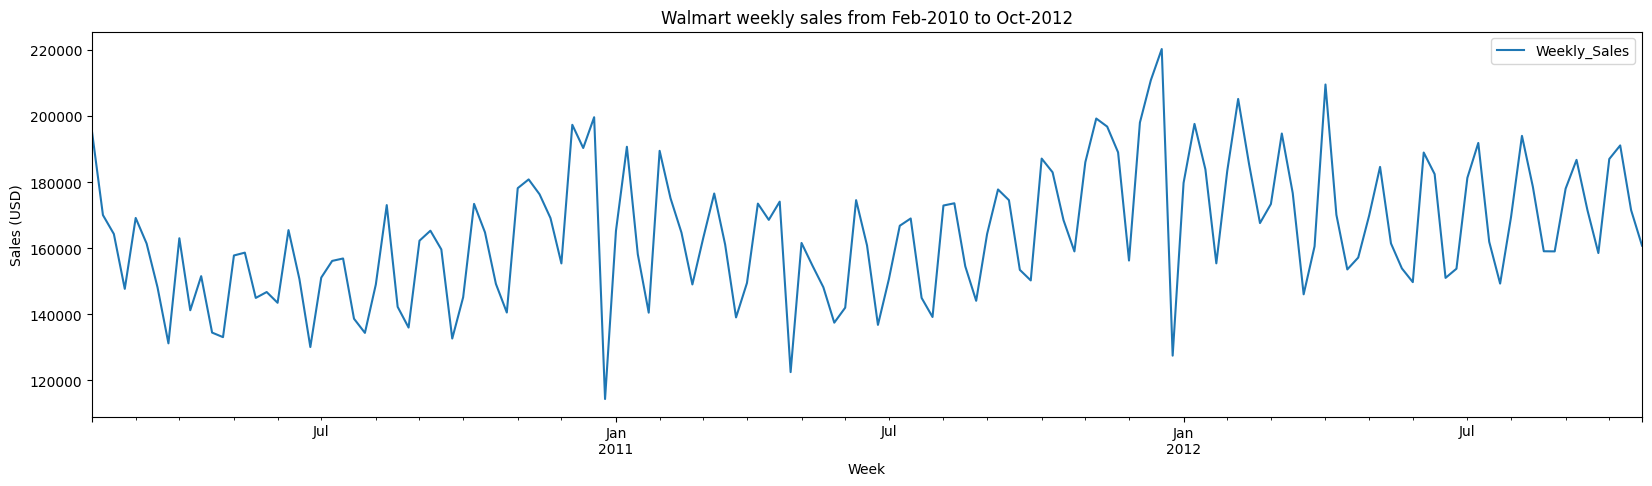

In [16]:
ts_store20.plot(figsize=(20,5))
plt.title('Walmart weekly sales from Feb-2010 to Oct-2012')
plt.xlabel('Week')
plt.ylabel('Sales (USD)');

We will proceed to split it into a training set and a test set. Considering the limited size of the dataset, the test set will be smaller, accounting for less than 20% of the total data.

In [17]:
split_date = '2012-05-31'

In [18]:
ts_train = ts_store20.loc[:'2012-05-31']
ts_test = ts_store20.loc['2012-05-31':]

In [19]:
print(ts_train.shape,ts_test.shape)

(121, 1) (22, 1)


## 2.1. ARIMA model

First, check stationary of the time series.

In [20]:
adfuller(ts_store20)

(-1.5244236378253921,
 0.5213965848010328,
 4,
 138,
 {'1%': -3.47864788917503,
  '5%': -2.882721765644168,
  '10%': -2.578065326612056},
 2807.549244540531)

In [21]:
p_value = adfuller(ts_store20)[1]
p_value > 0.05

True

Since p_value is greater than significance level of 0.05, the time series is not stationary.

In our analysis of the time series elements, we will begin by setting the period to 13. Although the dataset is not very large, we can still observe an upward trend on a yearly basis. However, when it comes to seasonality, no clear patterns emerge.

<Figure size 640x480 with 0 Axes>

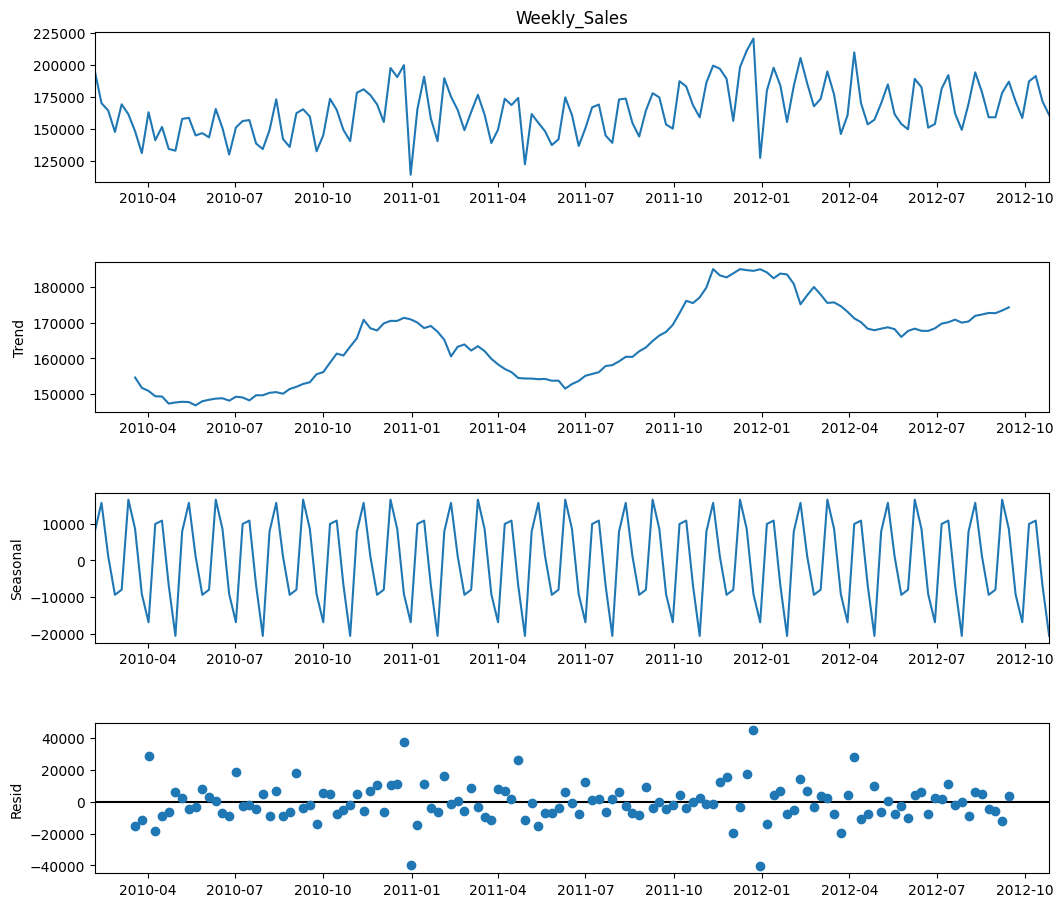

In [22]:
decomposition_additive = seasonal_decompose(ts_store20.Weekly_Sales, period=13)  
fig = plt.figure()  
fig = decomposition_additive.plot()  
fig.set_size_inches(12, 10)
plt.show();

In the upcoming steps, we will apply a detrending technique to the time series. Since we are unsure about the specific seasonality patterns and the exact number of steps for the upward trends, we will begin by trying differencing with a lag of 1. This approach involves taking the difference between each observation and its previous value to remove the trend component from the data.

##### Differencing train time series with lag 1

In [23]:
dif_1 = ts_store20.diff(1)
dif_1

,Weekly_Sales
Date,
2010-02-05,NaN
2010-02-12,-25180.29
2010-02-19,-5729.26
2010-02-26,-16614.63
2010-03-05,21471.52
...,...
2012-09-28,-12990.27
2012-10-05,28487.93
2012-10-12,4109.05


In [24]:
dif_1_dropna = dif_1.dropna()

In [25]:
#Check stationary of new series:
adfuller(dif_1_dropna)

(-13.616156541830877,
 1.8334363579196023e-25,
 3,
 138,
 {'1%': -3.47864788917503,
  '5%': -2.882721765644168,
  '10%': -2.578065326612056},
 2788.2005456673887)

In [26]:
p_value_1 = adfuller(dif_1_dropna)[1]
p_value_1 > 0.05

False

Suprisingly, the first differencing is a stationary time series.

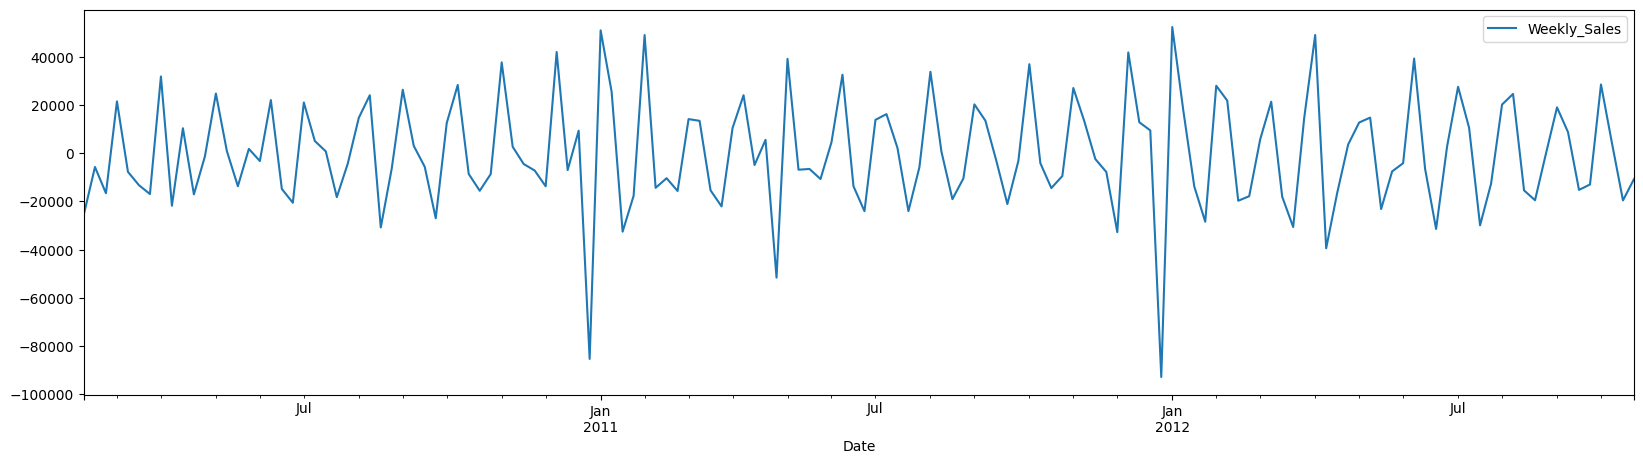

In [27]:
dif_1_dropna.plot(figsize=(20,5));

Although the first differencing of the sales time series still captures seasonality, it does render the series stationary. Despite this limitation, we can still proceed to input it into the model to get the predicted values.

Split 'dif_1' into train & test set.

In [28]:
dif_1_train = dif_1_dropna.loc[:'2012-05-31']
dif_1_test = dif_1_dropna.loc['2012-05-31':]

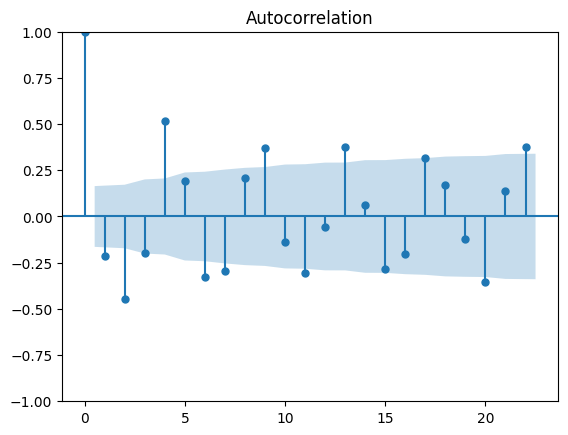

In [29]:
plot_acf(dif_1_dropna);

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


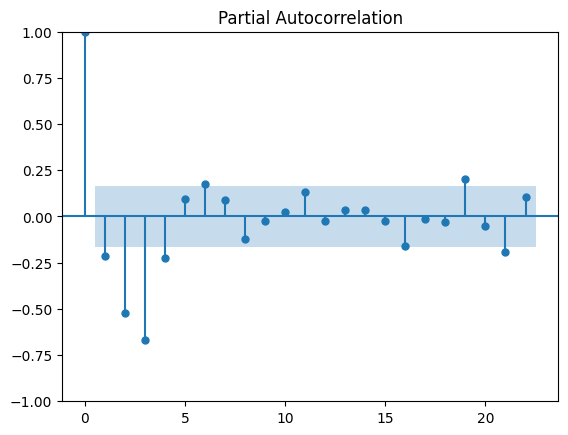

In [30]:
plot_pacf(dif_1_dropna);

To simplify the process of selecting the optimal values for p and q, we will utilize the pm.auto_arima function. This function will automatically determine the best options for p and q.

In [31]:
ARIMA_model_l = pm.auto_arima(dif_1_train, start_p=1, start_q=4,
                     max_p=4, max_q=4, d= 0, trace=True, stepwise=True, suppress_warnings=True,
                     error_action='ignore')

Performing stepwise search to minimize aic
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=2694.870, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2764.869, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2759.305, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2712.233, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2762.894, Time=0.00 sec
 ARIMA(0,0,4)(0,0,0)[0] intercept   : AIC=2695.807, Time=0.03 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=2702.796, Time=0.03 sec
 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=2660.438, Time=0.05 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=2661.556, Time=0.05 sec
 ARIMA(3,0,4)(0,0,0)[0] intercept   : AIC=2659.990, Time=0.07 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=2658.103, Time=0.05 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=2655.777, Time=0.04 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=2669.919, Time=0.03 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=2658.009, Time=0.03 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept

After utilizing the pm.auto_arima function, we have determined that the best options for p and q are 3 and 2, respectively. These values can now be used in our ARIMA model for further analysis.

In [32]:
best_ARIMA_model_1 = ARIMA(dif_1_train, order = (3,0,2))
result_best_ARIMA_1 = best_ARIMA_model_1.fit()

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


In [33]:
result_best_ARIMA_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Weekly_Sales   No. Observations:                  120
Model:                 ARIMA(3, 0, 2)   Log Likelihood               -1321.043
Date:                Sun, 16 Jul 2023   AIC                           2656.087
Time:                        22:03:10   BIC                           2675.599
Sample:                    02-12-2010   HQIC                          2664.011
                         - 05-25-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -344.4074    526.910     -0.654      0.513   -1377.133     688.318
ar.L1         -0.3560      0.179     -1.987      0.047      -0.707      -0.005
ar.L2         -0.7466      0.068    -10.920      0.000      -0.881      -0.613
ar.L3         -0.5139      0.132     -3.885      0.000      -0.773      -0.255
ma.L1         -0.5181      0.207     -2.508      0.012      -0.923      -0.113
ma.L2          0.3463      0.130      2.661      0.008       0.091       0.601
sigma2      2.108e+08      0.001   3.76e+11      0.000    2.11e+08    2.11e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                12.89
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               2.14   Skew:                            -0.29
Prob(H) (two-sided):                  0.02   Kurtosis:                         4.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.52e+27. Standard errors may be unstable.
"""

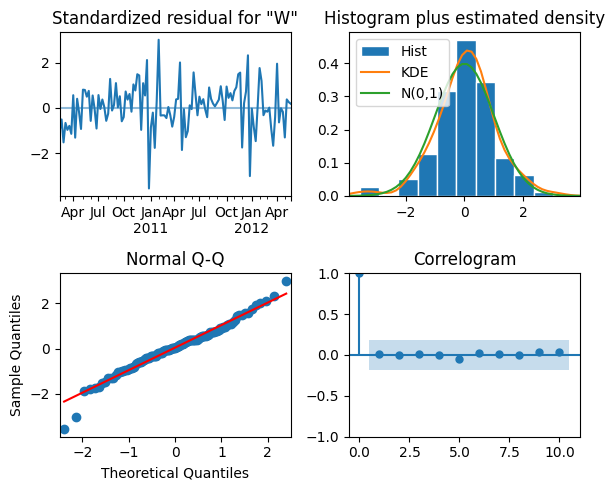

In [34]:
result_best_ARIMA_1.plot_diagnostics(figsize = (6,5))
plt.tight_layout()
plt.show()

Looking at the time series of lag 1, its residual likely looks normal distribution.

In [35]:
len(dif_1_train)

120

In [36]:
len(dif_1_test)

22

In [37]:
len(dif_1_train) + len(dif_1_test) - 1 

141

Calculate the predicted values for 1st differencing of test set.

In [38]:
dif_1_test_pred = result_best_ARIMA_1.predict(start=120,end=141)
dif_1_test_pred[0:5]

2012-06-01    11417.014386
2012-06-08    13514.510416
2012-06-15   -10346.758312
2012-06-22   -13174.455093
2012-06-29     4569.014530
Freq: W-FRI, Name: predicted_mean, dtype: float64

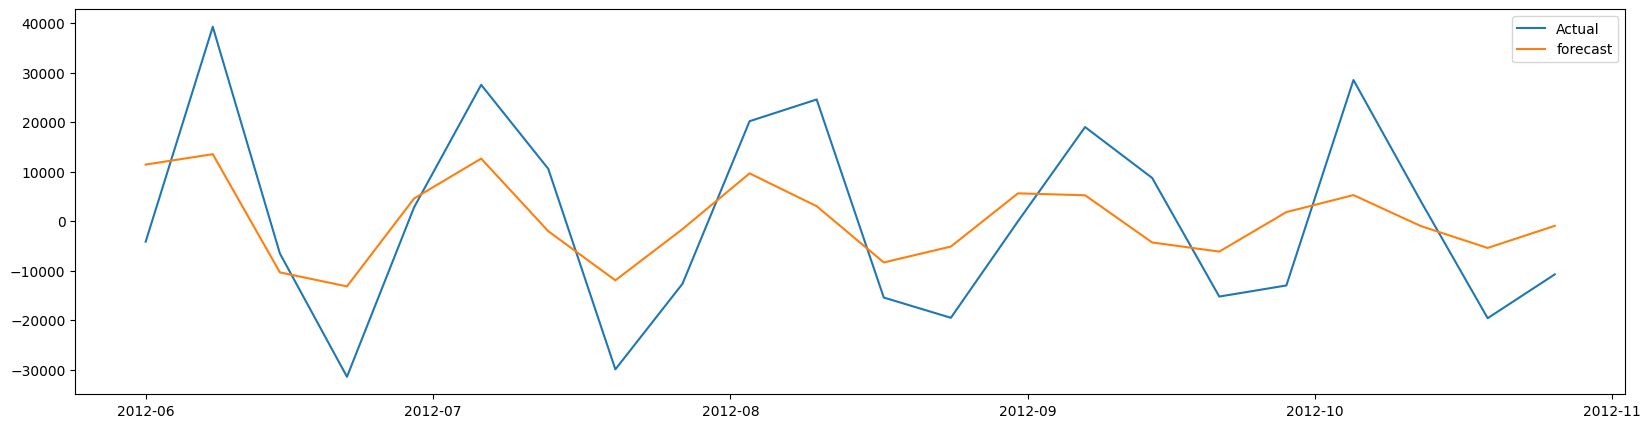

In [39]:
plt.figure(figsize=(20,5))
plt.plot(dif_1_test, label = 'Actual')
plt.plot(dif_1_test_pred, label = 'forecast')
plt.legend()
plt.xticks();

Upon analyzing the differences between the actual values and the predicted values, it becomes apparent that there are substantial discrepancies. This indicates that relying solely on 1st differencing for the ARIMA model may not produce accurate forecasts. To improve forecast accuracy, it is necessary to further analyze and decompose the time series data.

In [40]:
dif_1_test_forecast = ts_test.copy()
dif_1_test_forecast['Weekly_Sales_lag1'] = dif_1_test_forecast['Weekly_Sales'].shift(1)
dif_1_test_forecast['dif_1'] = dif_1_test_forecast['Weekly_Sales'].diff(1)
dif_1_test_forecast['dif_1_forecast'] = result_best_ARIMA_1.predict(start=120,end=141)

Using the ARIMA model, we can obtain the predicted differences for future periods. By adding these predicted differences to the sales of the previous week, we can calculate the forecasted weekly sales for the upcoming week.

In [41]:
ts_train[-1:]

,Weekly_Sales
Date,
2012-05-25,153894.9


In [42]:
dif_1_test_forecast['sum_forecast'] = 0
dif_1_test_forecast.iloc[0,4] = ts_train[-1:].iloc[0,0]
dif_1_test_forecast['sum_forecast1'] = dif_1_test_forecast['sum_forecast'] + dif_1_test_forecast['dif_1_forecast']
dif_1_test_forecast['Weekly_Sales_forecast'] = dif_1_test_forecast['sum_forecast1'].cumsum()

After lots of steps, we finally caculated the forecasted weekly sales.

In [43]:
dif_1_test_forecast

,Weekly_Sales,Weekly_Sales_lag1,dif_1,dif_1_forecast,sum_forecast,sum_forecast1,Weekly_Sales_forecast
Date,,,,,,,
2012-06-01,149742.17,NaN,NaN,11417.014386,153894.9,165311.914386,165311.914386
2012-06-08,188978.51,149742.17,39236.34,13514.510416,0.0,13514.510416,178826.424802
2012-06-15,182448.55,188978.51,-6529.96,-10346.758312,0.0,-10346.758312,168479.666490
2012-06-22,151023.66,182448.55,-31424.89,-13174.455093,0.0,-13174.455093,155305.211396
2012-06-29,153806.02,151023.66,2782.36,4569.014530,0.0,4569.014530,159874.225927
2012-07-06,181325.94,153806.02,27519.92,12625.322898,0.0,12625.322898,172499.548825
2012-07-13,191882.20,181325.94,10556.26,-2036.948791,0.0,-2036.948791,170462.600033
2012-07-20,161955.74,191882.20,-29926.46,-11949.935831,0.0,-11949.935831,158512.664202
2012-07-27,149301.45,161955.74,-12654.29,-1614.033183,0.0,-1614.033183,156898.631020


In [44]:
ARIMA_mse_dif1 = mean_squared_error(dif_1_test_forecast['Weekly_Sales'],dif_1_test_forecast['Weekly_Sales_forecast'])
ARIMA_mse_dif1

211887254.2447027

In [45]:
ARIMA_RMSE_dif1 = np.sqrt(ARIMA_mse_dif1)
ARIMA_RMSE_dif1

14556.347558529327

In [46]:
ARIMA_mae_dif1 = mean_absolute_error(dif_1_test_forecast['Weekly_Sales'],dif_1_test_forecast['Weekly_Sales_forecast'])
ARIMA_mae_dif1

11977.515736145968

In [47]:
summary_table.loc[1] = ['ARIMA_dif_1', 'Actual vs dif_1', round(ARIMA_RMSE_dif1), round(ARIMA_mae_dif1,2)]

summary_table

,Name,Model,RMSE,MAE
0,Baseline_1,Actual vs 1st lag,23330,18236.27
1,ARIMA_dif_1,Actual vs dif_1,14556,11977.52


When comparing the ARIMA model with the baseline model, we see that that applying the first differencing technique significantly improved the performance. The ARIMA model with first differencing reduced the RMSE from 23k to 14k, indicating a substantial decrease in the overall prediction error. Similarly, the MAE decreased from 18k to 12k, demonstrating a significant improvement in the accuracy of the model's predictions. 

To further improve forecast accuracy, deeper analysis and decomposition of the time series data would be necessary. However, it is important to note that such analysis would be extremely time-consuming, especially considering the number of combinations between stores and departments. Therefore, for the purpose of this analysis, we will not delve deeper into the decomposition of the time series data.

## 2.1. SARIMA model

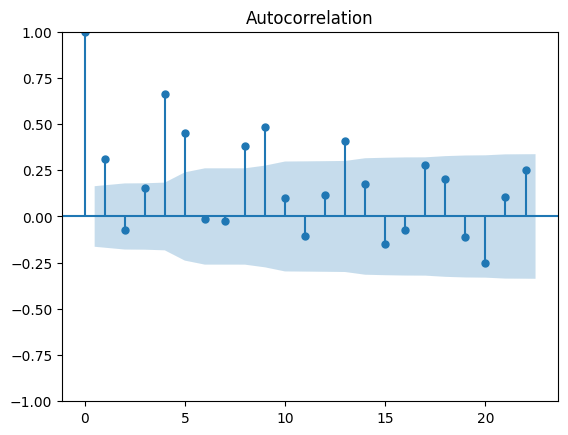

In [48]:
plot_acf(ts_store20);

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


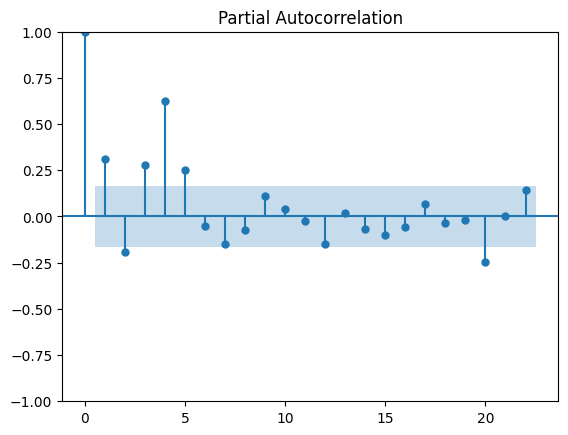

In [49]:
plot_pacf(ts_store20);

To apply the SARIMA model, it is essential to identify the underlying seasonality patterns present in the observed time series. However, in this case, the seasonality patterns are not evident. Nonetheless, we can make an assumption about the number of seasonal components and incorporate them into the SARIMA model. By doing so, we can assess how well the model performs and evaluate its effectiveness in capturing any potential seasonality present in the data.

In [50]:
ts_train = ts_store20.loc[:'2012-05-31']
ts_test = ts_store20.loc['2012-05-31':]

In [51]:
print(ts_train.shape,ts_test.shape)

(121, 1) (22, 1)


Let assume 12 weeks (around 3 months) for the frequency of the seasonlity.

In [107]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0,2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets (use 12 for frequency)
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [108]:
ans = []

# Fit SARIMA models and calculate AIC
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(ts_train,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}: AIC Calculated = {}'.format(comb, combs, output.aic))
        except:
            continue

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.33177D+01    |proj g|=  2.04281D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   2.043D-08   1.332D+01
  F =   13.317747160795943     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 0, 0) x (0, 0, 0, 12): AIC Calculated = 3224.894812912618
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0      

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.58510D+00    |proj g|=  4.76429D+00

At iterate    5    f=  9.06846D+00    |proj g|=  1.19355D-01

At iterate   10    f=  9.06305D+00    |proj g|=  3.12115D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     13      1     0     0   2.594D-06   9.063D+00
  F =   9.0630542720223310     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 0, 1) x (0, 1, 1, 12): AIC Calculated = 2199.259133829404
RU

ARIMA (0, 1, 0) x (0, 1, 1, 12): AIC Calculated = 2225.1451587745123
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02893D+01    |proj g|=  4.23608D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   4.236D-06   1.029D+01
  F =   10.289260329023550     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 1, 0) x (1, 0, 0, 12): AIC Calculated = 2494.000999623699
RUNNING THE L-BFGS-B CODE

           * * *

Machine prec

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt


At iterate    5    f=  9.88190D+00    |proj g|=  5.11487D-02

At iterate   10    f=  9.88011D+00    |proj g|=  3.71209D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     15      1     0     0   1.626D-06   9.880D+00
  F =   9.8801099043169707     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 1, 1) x (1, 0, 1, 12): AIC Calculated = 2398.986596844707
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.21433D+00    |proj g|=  1.52715D-01

A

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.06244D+01    |proj g|=  9.70314D-01

At iterate    5    f=  1.03005D+01    |proj g|=  1.09019D+00

At iterate   10    f=  1.02874D+01    |proj g|=  5.98937D-02

At iterate   15    f=  1.02868D+01    |proj g|=  2.65148D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     18      1     0     0   4.762D-05   1.029D+01
  F =   10.286791355713449     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt


At iterate    5    f=  1.02372D+01    |proj g|=  4.31219D-02

At iterate   10    f=  1.02362D+01    |proj g|=  5.94817D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     14      1     0     0   2.601D-07   1.024D+01
  F =   10.236228941196126     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (1, 0, 1) x (0, 1, 0, 12): AIC Calculated = 2483.1674037694625
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.72172D+00    |proj g|=  5.80695D+00



/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so 


At iterate   25    f=  9.99095D+00    |proj g|=  2.17769D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     51      1     0     0   2.178D-03   9.991D+00
  F =   9.9909526546439462     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 1) x (1, 0, 1, 12): AIC Calculated = 2427.810542423835
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.18620D+00    |proj g|=  1.18389D-01

At iterate    5    f=  9.17450D+00    |proj g|=  9.16835D-02

A

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     11      1     0     0   6.794D-06   9.167D+00
  F =   9.1674964880914143     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (1, 1, 0) x (0, 1, 1, 12): AIC Calculated = 2224.5341501181224
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01695D+01    |proj g|=  3.22893D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of se

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt


At iterate    5    f=  8.93281D+00    |proj g|=  4.27002D-02

At iterate   10    f=  8.93229D+00    |proj g|=  9.37881D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     13      1     0     0   9.379D-06   8.932D+00
  F =   8.9322916474224634     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (1, 1, 1) x (0, 1, 1, 12): AIC Calculated = 2169.6145786762363
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03265D+01    |proj g|=  5.71055D-01



/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt

In [109]:
sarima_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
sarima_df.loc[sarima_df['aic'].idxmin()]

pdq         (1, 1, 1)
pdqs    (0, 1, 1, 12)
aic       2169.614579
Name: 59, dtype: object

In [111]:
# Plug the optimal parameter values into a new SARIMAX model
sarima_model = sm.tsa.statespace.SARIMAX(ts_train, 
                                        order=(1, 1, 1), 
                                        seasonal_order=(0, 1, 1, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
sarima_fit = sarima_model.fit()

print(sarima_fit.summary().tables[1])

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.17509D+00    |proj g|=  3.04825D-01

At iterate    5    f=  8.93281D+00    |proj g|=  4.27002D-02

At iterate   10    f=  8.93229D+00    |proj g|=  9.37881D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     13      1     0     0   9.379D-06   8.932D+00
  F =   8.9322916474224634     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                 coef    std err          z      P>|z|      [0.025    

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


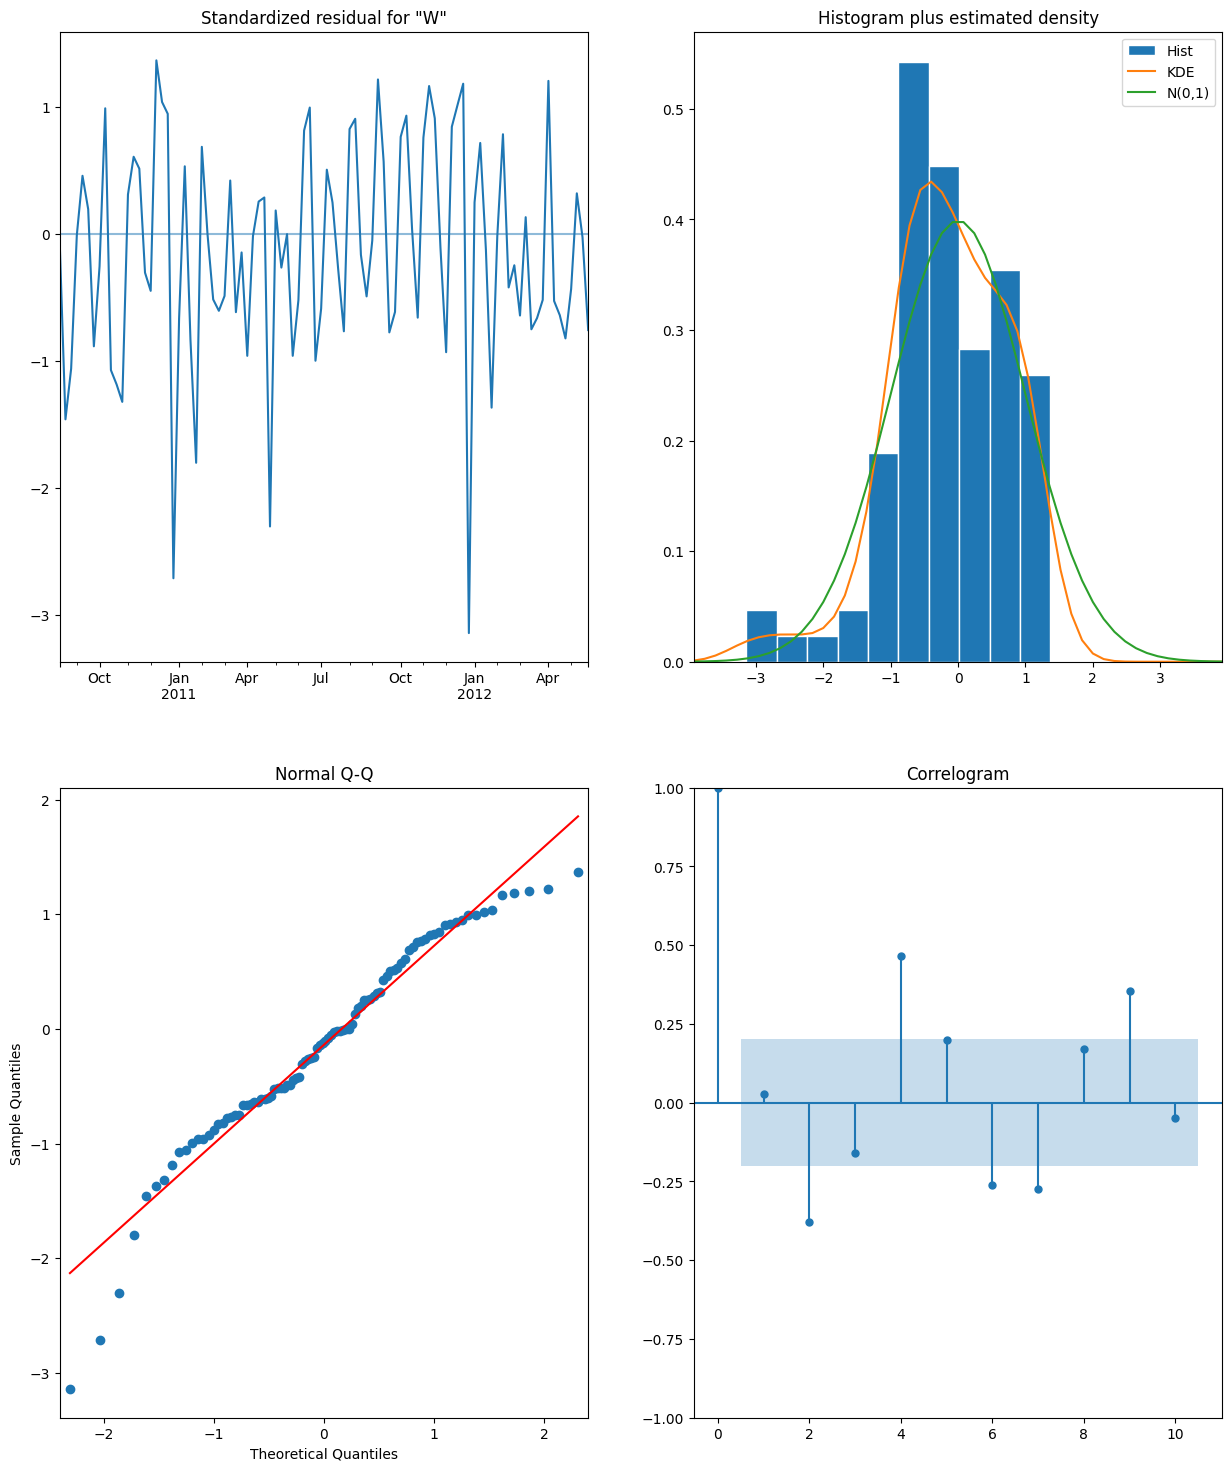

In [112]:
# Call plot_diagnostics() on the results calculated above 
sarima_fit.plot_diagnostics(figsize=(15, 18))
plt.show()

The residuals unlikely follow normal distribution, indicating that our initial assumption about the seasonality may not be correct. Further analysis and steps are required to identify and capture the appropriate seasonality patterns in the data.

In [113]:
Start_date_test = '2012-06-01'
End_date_test = '2012-10-26'

In [114]:
y_pred_test = sarima_fit.predict(start=Start_date_test,end=End_date_test, dynamic=False)

In [115]:
y_pred_test

2012-06-01    179729.469786
2012-06-08    176090.475519
2012-06-15    147781.895819
2012-06-22    162050.720542
2012-06-29    184634.639444
2012-07-06    166665.229623
2012-07-13    155926.312183
2012-07-20    164886.097584
2012-07-27    174180.368653
2012-08-03    177535.649903
2012-08-10    157680.080190
2012-08-17    162359.709811
2012-08-24    179550.481510
2012-08-31    174867.119536
2012-09-07    146432.356427
2012-09-14    160685.935319
2012-09-21    183268.012178
2012-09-28    165298.379795
2012-10-05    154559.435465
2012-10-12    163519.217618
2012-10-19    172813.488294
2012-10-26    176168.769496
Freq: W-FRI, Name: predicted_mean, dtype: float64

In [116]:
ts_test_df = ts_test.copy()

In [117]:
ts_test_df.loc[:,'Weekly_Sales_forecast'] = y_pred_test
ts_test_df

,Weekly_Sales,Weekly_Sales_forecast
Date,,
2012-06-01,149742.17,179729.469786
2012-06-08,188978.51,176090.475519
2012-06-15,182448.55,147781.895819
2012-06-22,151023.66,162050.720542
2012-06-29,153806.02,184634.639444
2012-07-06,181325.94,166665.229623
2012-07-13,191882.20,155926.312183
2012-07-20,161955.74,164886.097584
2012-07-27,149301.45,174180.368653


In [118]:
ts_test_df['Residual'] = ts_test_df['Weekly_Sales'] - ts_test_df['Weekly_Sales_forecast']
ts_test_df

,Weekly_Sales,Weekly_Sales_forecast,Residual
Date,,,
2012-06-01,149742.17,179729.469786,-29987.299786
2012-06-08,188978.51,176090.475519,12888.034481
2012-06-15,182448.55,147781.895819,34666.654181
2012-06-22,151023.66,162050.720542,-11027.060542
2012-06-29,153806.02,184634.639444,-30828.619444
2012-07-06,181325.94,166665.229623,14660.710377
2012-07-13,191882.20,155926.312183,35955.887817
2012-07-20,161955.74,164886.097584,-2930.357584
2012-07-27,149301.45,174180.368653,-24878.918653


In [119]:
mse_sarima = mean_squared_error(ts_test_df['Weekly_Sales'],ts_test_df['Weekly_Sales_forecast'])
mse_sarima

532332871.35352784

In [120]:
RMSE_sarima = np.sqrt(mse_sarima)
RMSE_sarima

23072.339962681024

In [121]:
mae_sarima = mean_absolute_error(ts_test_df['Weekly_Sales'],ts_test_df['Weekly_Sales_forecast'])
mae_sarima

20349.459943131846

In [122]:
summary_table.loc[2] = ['SARIMAX', 'SARIMA', round(RMSE_sarima), round(mae_sarima,2)]

summary_table

,Name,Model,RMSE,MAE
0,Baseline_1,Actual vs 1st lag,23330,18236.27
1,ARIMA_dif_1,Actual vs dif_1,14556,11977.52
2,SARIMAX,SARIMA,23072,20349.46
3,XGBRegressor,Without tuning,16804,14958.97


## 3. Machine learning models

Define train set & test set for machine learning models. Train & test dataset will be a dataframe.

In [123]:
split_date = '2012-05-31'
train = data_store20.loc[ts_store20.index <= split_date]
test = data_store20.loc[ts_store20.index > split_date]

In [124]:
print(train.shape,test.shape)

(121, 15) (22, 15)


In [125]:
#Train & test dataset:
X_train = train.drop(columns=['Date','Weekly_Sales'])
y_train = train['Weekly_Sales']

X_test = test.drop(columns=['Date','Weekly_Sales'])
y_test = test['Weekly_Sales']

In [126]:
data_store20.head()

,Date,Weekly_Sales,IsHoliday,Week,Year,Month,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,2010-02-05,195223.84,0,5,2010,2,25.92,2.784,0.0,0.0,0.0,0.0,0.0,204.247194,8.187
1,2010-02-12,170043.55,1,6,2010,2,22.12,2.773,0.0,0.0,0.0,0.0,0.0,204.385747,8.187
2,2010-02-19,164314.29,0,7,2010,2,25.43,2.745,0.0,0.0,0.0,0.0,0.0,204.432100,8.187
3,2010-02-26,147699.66,0,8,2010,2,32.32,2.754,0.0,0.0,0.0,0.0,0.0,204.463087,8.187
4,2010-03-05,169171.18,0,9,2010,3,31.75,2.777,0.0,0.0,0.0,0.0,0.0,204.494073,8.187


Plot train & test dataset

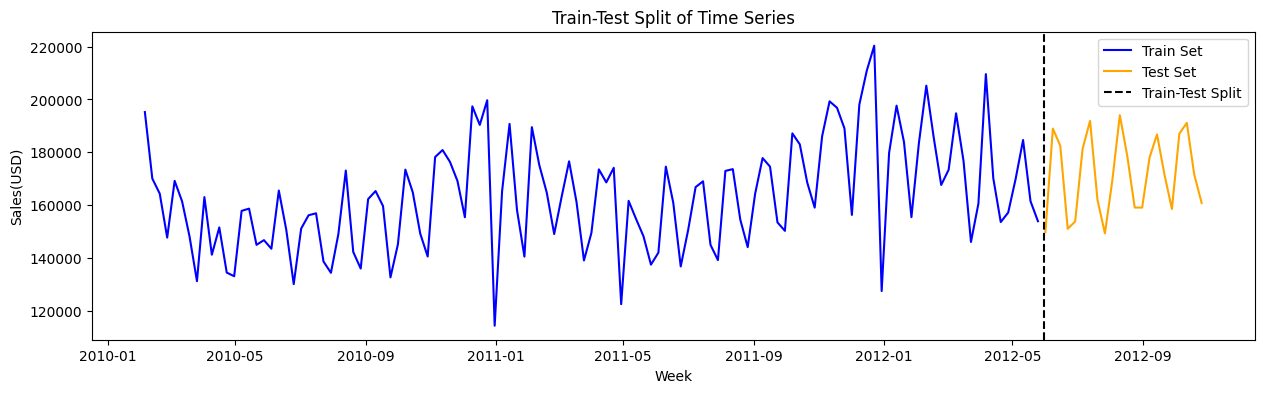

In [127]:
def plot_train_test_split(time_series, split_date, test_color='red'):
    plt.figure(figsize=(15, 4))
    
    # Plot the train set with a blue color
    plt.plot(time_series.loc[time_series.index < split_date], color='blue', label='Train Set')
    
    # Plot the test set with the specified color
    plt.plot(time_series.loc[time_series.index >= split_date], color=test_color, label='Test Set')
    
    # Add a vertical line to indicate the train-test split date
    plt.axvline(pd.to_datetime(split_date), color='black', linestyle='--', label='Train-Test Split')
    
    plt.xlabel('Week')
    plt.ylabel('Sales(USD)')
    plt.legend()
    plt.title('Train-Test Split of Time Series')
    plt.show()

# Example usage
plot_train_test_split(ts_store20, split_date,"orange")

### 3.1. XGBRegressor model

### 3.1.1. XGBRegressor without tuning & without Onehotencoder

In [128]:
X_train.columns

Index(['IsHoliday', 'Week', 'Year', 'Month', 'Temperature', 'Fuel_Price',
       'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI',
       'Unemployment'],
      dtype='object')

In [129]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(121, 13) (121,) (22, 13) (22,)


In [130]:
numeric_col = ['Temperature', 'Fuel_Price','CPI','Unemployment','IsHoliday']

numeric_col_impute = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']

ordinal_col = ['Week', 'Year', 'Month']



Set up pipeline

In [131]:
#Pipeline prepration:
numeric_pipeline = Pipeline([ ('minmaxscaler', MinMaxScaler())])
numeric_pipeline_impute = Pipeline([ ('num_imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('minmaxscaler', MinMaxScaler())])

ordinal_pipeline = Pipeline([
    ('minmaxscaler', MinMaxScaler())])

#Column transform:
ct = ColumnTransformer(
    [("numpipe", numeric_pipeline, numeric_col), 
     ("numpipe_impute", numeric_pipeline_impute, numeric_col_impute),
     ("ordipipe", ordinal_pipeline, ordinal_col)])


In [132]:
#Model pipeline:
XGBoost_pipe = Pipeline([('preprocess', ct),
                      ('XGBoostmodel',XGBRegressor())])
XGBoost_pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('numpipe',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['Temperature', 'Fuel_Price',
                                                   'CPI', 'Unemployment',
                                                   'IsHoliday']),
                                                 ('numpipe_impute',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['MarkDown1', 'MarkDown2',
                                                   'MarkDo...
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=None, ...))])

In [133]:
XGBoost_pipe.fit(X_train,y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('numpipe',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['Temperature', 'Fuel_Price',
                                                   'CPI', 'Unemployment',
                                                   'IsHoliday']),
                                                 ('numpipe_impute',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['MarkDown1', 'MarkDown2',
                                                   'MarkDo...
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=None, ...))])

#### Evaluation the model with X_test

In [134]:
y_pred_test_XGboost = XGBoost_pipe.predict(X_test)

In [135]:
y_pred_test_XGboost

array([172565.52, 158515.17, 164163.84, 163577.39, 167583.55, 160970.22,
       172642.69, 158326.67, 175119.88, 173195.1 , 177364.6 , 157771.66,
       167990.42, 167646.95, 154258.33, 168296.39, 152583.78, 167705.23,
       175311.28, 187663.86, 156282.17, 158159.77], dtype=float32)

In [136]:
test= test.reset_index().drop('index', axis=1)
test.loc[:, 'y_pred_test_XGboost'] = pd.Series(y_pred_test_XGboost)

In [137]:
y_pred_test_XGboost_ts = test[['Date','y_pred_test_XGboost']]
y_pred_test_XGboost_ts.loc[:, 'Date'] = pd.to_datetime(y_pred_test_XGboost_ts['Date'])
y_pred_test_XGboost_ts.set_index('Date',inplace=True)

Build up a function called 'plot_train_test_split_pred' to visualize actual sales & foreacasted sales.

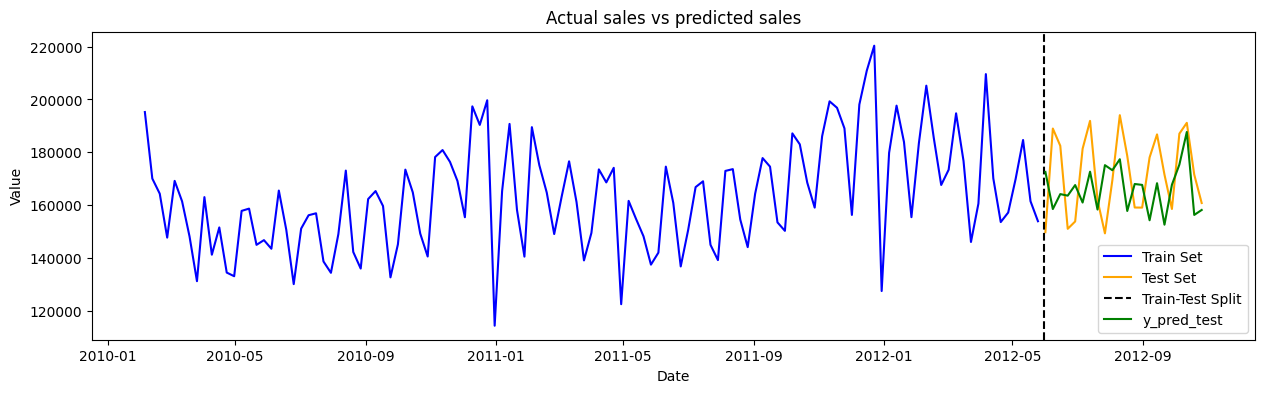

In [138]:
def plot_train_test_split_pred (time_series, split_date, y_pred_ts,test_color='red', y_pred_color='green'):
    plt.figure(figsize=(15, 4))

    # Plot the train set with a blue color
    plt.plot(time_series.loc[time_series.index < split_date], color='blue', label='Train Set')

    # Plot the test set with the specified color
    plt.plot(time_series.loc[time_series.index >= split_date], color=test_color, label='Test Set')

    # Add a vertical line to indicate the train-test split date
    plt.axvline(pd.to_datetime(split_date), color='black', linestyle='--', label='Train-Test Split')

    # Plot the y_pred values if provided
    plt.plot(y_pred_ts, color=y_pred_color, label='y_pred_test')

    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.title('Actual sales vs predicted sales')
    plt.show()
    
plot_train_test_split_pred (ts_store20, split_date,y_pred_test_XGboost_ts,test_color="orange", y_pred_color='green')

In [139]:
test_mse_xgboost = mean_squared_error(y_pred_test_XGboost,y_test)
test_mse_xgboost

282374259.58526653

In [140]:
test_RMSE_xgboost = np.sqrt(test_mse_xgboost)
test_RMSE_xgboost

16803.99534590707

In [141]:
test_mae_xgboost = mean_absolute_error(y_pred_test_XGboost,y_test)
test_mae_xgboost

14958.967244318184

In [142]:
features_importance_xgboost = pd.DataFrame(list(zip(X_train.columns,XGBoost_pipe[1].feature_importances_)),columns=['Features','Importance_level'])
features_importance_xgboost.sort_values(by ='Importance_level',ascending=False)

,Features,Importance_level
7,MarkDown2,0.223805
9,MarkDown4,0.173806
8,MarkDown3,0.141830
10,MarkDown5,0.107869
2,Year,0.091604
3,Month,0.086820
0,IsHoliday,0.049081
12,Unemployment,0.043927
6,MarkDown1,0.036000
1,Week,0.027807


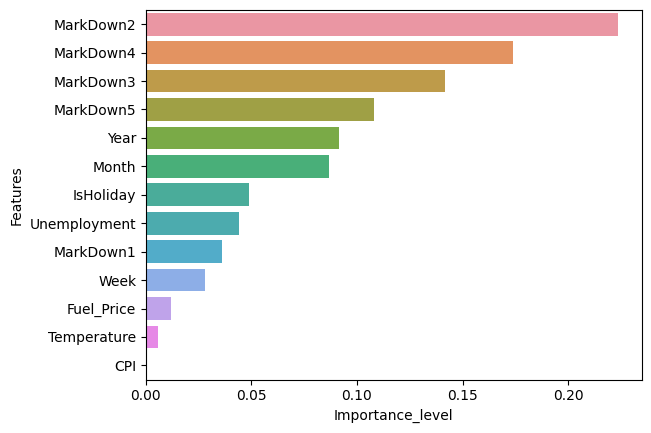

In [143]:
sns.barplot(data= features_importance_xgboost.sort_values(by ='Importance_level',ascending=False), y='Features',x='Importance_level');

In [144]:
summary_table.loc[3] = ['XGBRegressor', 'Without tuning', round(test_RMSE_xgboost), round(test_mae_xgboost,2)]

summary_table

,Name,Model,RMSE,MAE
0,Baseline_1,Actual vs 1st lag,23330,18236.27
1,ARIMA_dif_1,Actual vs dif_1,14556,11977.52
2,SARIMAX,SARIMA,23072,20349.46
3,XGBRegressor,Without tuning,16804,14958.97


### 3.1.2. XGBRegressor + tuning

In [145]:
param_grid_XGBoost = {
#     'XGBoostmodel__base_score': [0.5],
    'XGBoostmodel__n_estimators': np.arange(10,100,10),
    'XGBoostmodel__max_depth': np.arange(3,7,1),
    'XGBoostmodel__learning_rate': np.arange(0.1,0.5,0.02),
    'XGBoostmodel__gamma': [0,5,10],
    'XGBoostmodel__colsample_bytree': [.5,0.6,0.7,0.8,],
    
}

In [146]:
tune_XGBoost = GridSearchCV(estimator=XGBoost_pipe, 
                       param_grid=param_grid_XGBoost,cv=3)

In [148]:
tune_XGBoost.fit(X_train,y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('numpipe',
                                                                         Pipeline(steps=[('minmaxscaler',
                                                                                          MinMaxScaler())]),
                                                                         ['Temperature',
                                                                          'Fuel_Price',
                                                                          'CPI',
                                                                          'Unemployment',
                                                                          'IsHoliday']),
                                                                        ('numpipe_impute',
                                                                         Pipeline(steps=[('num_imputer',
                                                                                          SimpleImputer(fill_value=0,
                                                                                                        strategy='constant')),
                                                                                         ('minmaxscaler',
                                                                                          MinMaxScaler())]),
                                                                         ['Ma...
                                                     random_state=None, ...))]),
             param_grid={'XGBoostmodel__colsample_bytree': [0.5, 0.6, 0.7, 0.8],
                         'XGBoostmodel__gamma': [0, 5, 10],
                         'XGBoostmodel__learning_rate': array([0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 , 0.22, 0.24, 0.26, 0.28, 0.3 ,
       0.32, 0.34, 0.36, 0.38, 0.4 , 0.42, 0.44, 0.46, 0.48]),
                         'XGBoostmodel__max_depth': array([3, 4, 5, 6]),
                         'XGBoostmodel__n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])})

In [149]:
tune_XGBoost.best_params_

{'XGBoostmodel__colsample_bytree': 0.7,
 'XGBoostmodel__gamma': 0,
 'XGBoostmodel__learning_rate': 0.38,
 'XGBoostmodel__max_depth': 5,
 'XGBoostmodel__n_estimators': 20}

In [150]:
best_model_XGBoost = tune_XGBoost.best_estimator_
best_model_XGBoost

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('numpipe',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['Temperature', 'Fuel_Price',
                                                   'CPI', 'Unemployment',
                                                   'IsHoliday']),
                                                 ('numpipe_impute',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['MarkDown1', 'MarkDown2',
                                                   'MarkDo...
                              feature_types=None, gamma=0, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=0.38,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=5, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=20,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=None, ...))])

### Evaluate the model with X_test

In [151]:
y_pred_XGBoost_tune = best_model_XGBoost.predict(X_test)

In [152]:
y_pred_XGBoost_tune

array([171352.19, 153981.08, 162031.89, 173604.86, 157916.77, 160811.98,
       164514.66, 158244.64, 170527.4 , 164994.84, 170795.9 , 153411.75,
       171619.38, 164980.7 , 164672.62, 169495.83, 153030.14, 159739.25,
       157739.61, 181075.2 , 143636.64, 148215.14], dtype=float32)

In [153]:
test= test.reset_index().drop('index', axis=1)
test.loc[:, 'y_pred_XGBoost_tune'] = pd.Series(y_pred_XGBoost_tune)
y_pred_test_XGboost_tune_ts = test[['Date','y_pred_XGBoost_tune']]
y_pred_test_XGboost_tune_ts.loc[:, 'Date'] = pd.to_datetime(y_pred_test_XGboost_tune_ts['Date'])
y_pred_test_XGboost_tune_ts.set_index('Date',inplace=True)

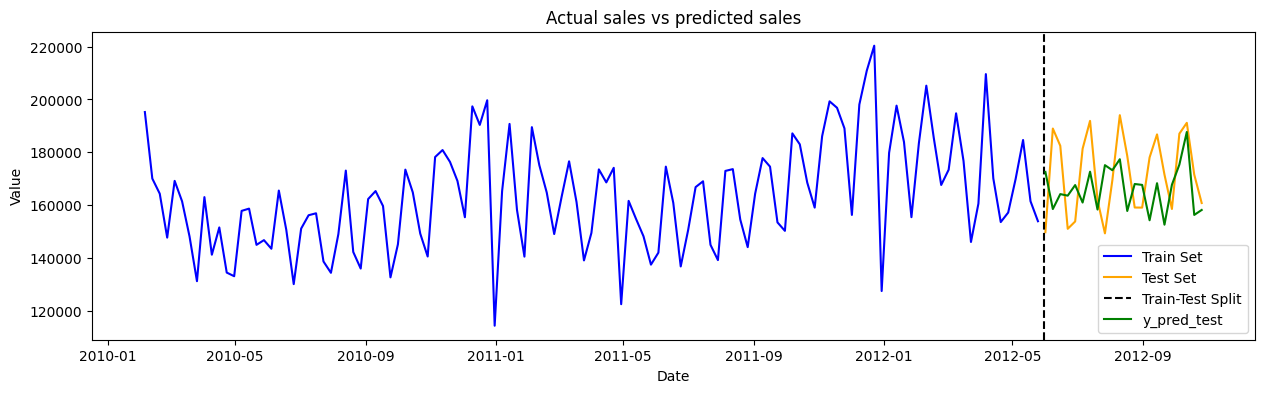

In [154]:
plot_train_test_split_pred (ts_store20, split_date,y_pred_test_XGboost_ts,test_color="orange", y_pred_color='green')

In [155]:
mse_xgboost_tune = mean_squared_error(y_test,y_pred_XGBoost_tune)
mse_xgboost_tune

380560105.8291639

In [156]:
RMSE_xgboost_tune = np.sqrt(mse_xgboost_tune)
RMSE_xgboost_tune

19507.949811017144

In [157]:
mae_xgboost_tune = mean_absolute_error(y_test,y_pred_XGBoost_tune)
mae_xgboost_tune

17184.327244318185

In [158]:
feat_imp_XGBoost_tune = best_model_XGBoost['XGBoostmodel'].feature_importances_
feat_imp_XGBoost_tune

array([0.12401748, 0.05263221, 0.17340481, 0.03646686, 0.02465905,
       0.06485005, 0.03835523, 0.08934009, 0.1035073 , 0.10029145,
       0.14383441, 0.        , 0.04864104], dtype=float32)

In [159]:
features_importance_xgboost_tune = pd.DataFrame(list(zip(X_train.columns,best_model_XGBoost[1].feature_importances_)),columns=['Features','Importance_level'])
features_importance_xgboost_tune.sort_values(by ='Importance_level',ascending=False)

,Features,Importance_level
2,Year,0.173405
10,MarkDown5,0.143834
0,IsHoliday,0.124017
8,MarkDown3,0.103507
9,MarkDown4,0.100291
7,MarkDown2,0.089340
5,Fuel_Price,0.064850
1,Week,0.052632
12,Unemployment,0.048641
6,MarkDown1,0.038355


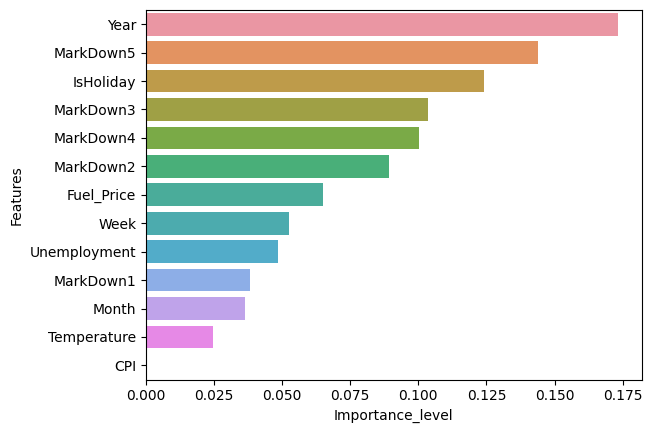

In [160]:
sns.barplot(data= features_importance_xgboost_tune.sort_values(by ='Importance_level',ascending=False), y='Features',x='Importance_level');

#### Evaluate the error

In [161]:
xgboost_tune_error = test['Weekly_Sales'] - test['y_pred_XGBoost_tune']
xgboost_tune_error.sort_values(ascending=False)

1     34997.431875
18    29287.440625
20    27901.299375
6     27367.543750
11    25191.780000
10    23236.573750
5     20513.955625
2     20416.659375
16    18499.249375
15    17263.281875
14    13370.105000
21    12570.839375
19    10060.896875
9      4476.616250
7      3711.099375
17    -1200.130000
4     -4110.745625
13    -5931.133125
12   -12531.245000
8    -21225.956250
0    -21610.017500
3    -22581.199375
dtype: float64

In [162]:
abs(xgboost_tune_error.sort_values(ascending=False))

1     34997.431875
18    29287.440625
20    27901.299375
6     27367.543750
11    25191.780000
10    23236.573750
5     20513.955625
2     20416.659375
16    18499.249375
15    17263.281875
14    13370.105000
21    12570.839375
19    10060.896875
9      4476.616250
7      3711.099375
17     1200.130000
4      4110.745625
13     5931.133125
12    12531.245000
8     21225.956250
0     21610.017500
3     22581.199375
dtype: float64

In [163]:
summary_table.loc[4] = ['XGBRegressor', '+ tuning', round(RMSE_xgboost_tune), round(mae_xgboost_tune,2)]

summary_table

,Name,Model,RMSE,MAE
0,Baseline_1,Actual vs 1st lag,23330,18236.27
1,ARIMA_dif_1,Actual vs dif_1,14556,11977.52
2,SARIMAX,SARIMA,23072,20349.46
3,XGBRegressor,Without tuning,16804,14958.97
4,XGBRegressor,+ tuning,19508,17184.33


## 3.2.RandomForestRegressor model

### 3.2.1. RandomForestRegressor without tuning

In [164]:
#Model pipeline:
rforestreg_pipe = Pipeline([('preprocess', ct),
                      ('Rforestregressor',RandomForestRegressor())])
rforestreg_pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('numpipe',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['Temperature', 'Fuel_Price',
                                                   'CPI', 'Unemployment',
                                                   'IsHoliday']),
                                                 ('numpipe_impute',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['MarkDown1', 'MarkDown2',
                                                   'MarkDown3', 'MarkDown4',
                                                   'MarkDown5']),
                                                 ('ordipipe',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['Week', 'Year', 'Month'])])),
                ('Rforestregressor', RandomForestRegressor())])

In [165]:
rforestreg_pipe.fit(X_train,y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('numpipe',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['Temperature', 'Fuel_Price',
                                                   'CPI', 'Unemployment',
                                                   'IsHoliday']),
                                                 ('numpipe_impute',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['MarkDown1', 'MarkDown2',
                                                   'MarkDown3', 'MarkDown4',
                                                   'MarkDown5']),
                                                 ('ordipipe',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['Week', 'Year', 'Month'])])),
                ('Rforestregressor', RandomForestRegressor())])

#### Evaluation the model with X_test

In [166]:
y_pred_test_rforestreg = rforestreg_pipe.predict(X_test)

In [167]:
test= test.reset_index().drop('index', axis=1)
test.loc[:, 'y_pred_test_rforestreg'] = pd.Series(y_pred_test_rforestreg)

In [168]:
y_pred_test_rforestreg_ts = test[['Date','y_pred_test_rforestreg']]
y_pred_test_rforestreg_ts.loc[:, 'Date'] = pd.to_datetime(y_pred_test_rforestreg_ts['Date'])
y_pred_test_rforestreg_ts.set_index('Date',inplace=True)

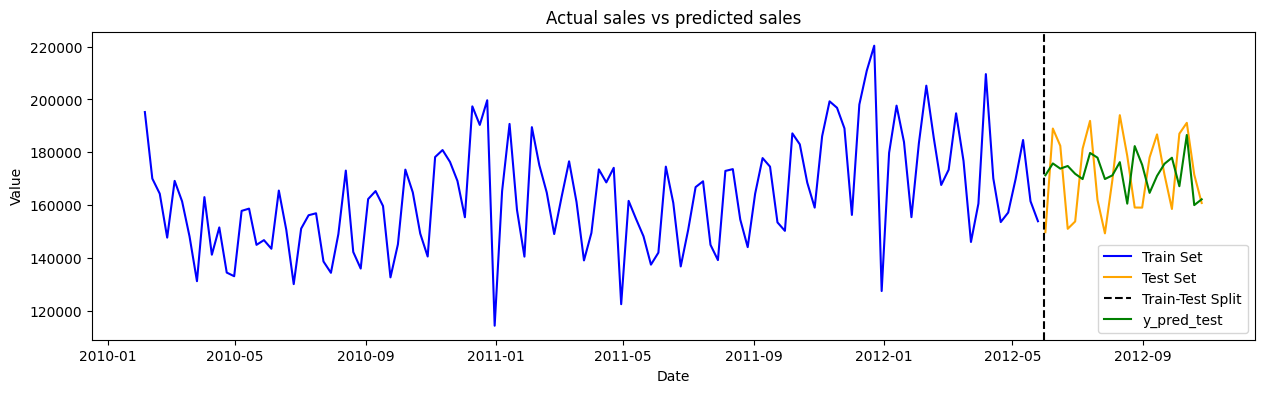

In [169]:
plot_train_test_split_pred (ts_store20, split_date,y_pred_test_rforestreg_ts,test_color="orange", y_pred_color='green')

In [170]:
mse_rforestreg = mean_squared_error(y_test,y_pred_test_rforestreg)
mse_rforestreg

244547943.65076068

In [171]:
RMSE_rforestreg = np.sqrt(mse_rforestreg)
RMSE_rforestreg

15638.028764865496

In [172]:
mae_rforestreg = mean_absolute_error(y_test,y_pred_test_rforestreg)
mae_rforestreg

14202.633563636378

In [173]:
features_importance_rforestreg = pd.DataFrame(list(zip(X_train.columns,rforestreg_pipe[1].feature_importances_)),columns=['Features','Importance_level'])
features_importance_rforestreg.sort_values(by ='Importance_level',ascending=False)

,Features,Importance_level
0,IsHoliday,0.284051
10,MarkDown5,0.153086
9,MarkDown4,0.130695
2,Year,0.125572
1,Week,0.099679
3,Month,0.059156
7,MarkDown2,0.039442
12,Unemployment,0.033287
8,MarkDown3,0.023421
5,Fuel_Price,0.020429


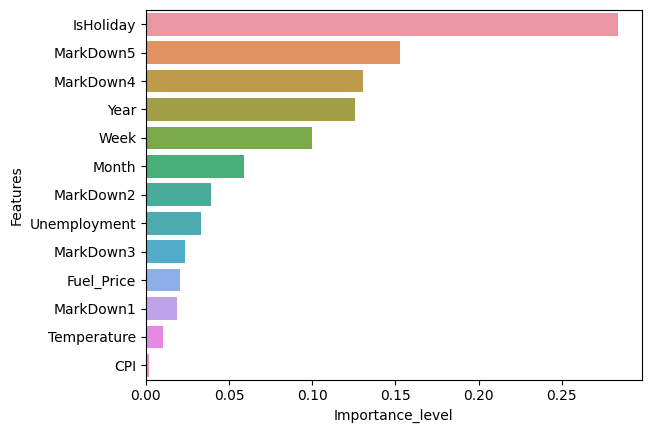

In [174]:
sns.barplot(data= features_importance_rforestreg.sort_values(by ='Importance_level',ascending=False), y='Features',x='Importance_level');

In [175]:
summary_table.loc[5] = ['Rforestregressor', ' withou tuning', round(RMSE_rforestreg), round(mae_rforestreg,2)]

summary_table

,Name,Model,RMSE,MAE
0,Baseline_1,Actual vs 1st lag,23330,18236.27
1,ARIMA_dif_1,Actual vs dif_1,14556,11977.52
2,SARIMAX,SARIMA,23072,20349.46
3,XGBRegressor,Without tuning,16804,14958.97
4,XGBRegressor,+ tuning,19508,17184.33
5,Rforestregressor,withou tuning,15638,14202.63


### 3.2.2. RandomForestRegressor + tuning

In [176]:
param_grid_rforestreg = {
    'Rforestregressor__max_depth': np.arange(3,11,1),
    'Rforestregressor__min_samples_split': np.arange(3,11,1)
}

In [177]:
tune_rforestreg = GridSearchCV(estimator=rforestreg_pipe, 
                       param_grid=param_grid_rforestreg)

In [178]:
tune_rforestreg.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('numpipe',
                                                                         Pipeline(steps=[('minmaxscaler',
                                                                                          MinMaxScaler())]),
                                                                         ['Temperature',
                                                                          'Fuel_Price',
                                                                          'CPI',
                                                                          'Unemployment',
                                                                          'IsHoliday']),
                                                                        ('numpipe_impute',
                                                                         Pipeline(steps=[('num_imputer',
                                                                                          SimpleImputer(fill_value=0,
                                                                                                        strategy='constant')),
                                                                                         ('minmaxscaler',
                                                                                          MinMaxScaler())]),
                                                                         ['MarkDown1',
                                                                          'MarkDown2',
                                                                          'MarkDown3',
                                                                          'MarkDown4',
                                                                          'MarkDown5']),
                                                                        ('ordipipe',
                                                                         Pipeline(steps=[('minmaxscaler',
                                                                                          MinMaxScaler())]),
                                                                         ['Week',
                                                                          'Year',
                                                                          'Month'])])),
                                       ('Rforestregressor',
                                        RandomForestRegressor())]),
             param_grid={'Rforestregressor__max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10]),
                         'Rforestregressor__min_samples_split': array([ 3,  4,  5,  6,  7,  8,  9, 10])})

In [179]:
tune_rforestreg.best_params_

{'Rforestregressor__max_depth': 6, 'Rforestregressor__min_samples_split': 9}

In [180]:
best_model_rforestreg = tune_rforestreg.best_estimator_
best_model_rforestreg

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('numpipe',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['Temperature', 'Fuel_Price',
                                                   'CPI', 'Unemployment',
                                                   'IsHoliday']),
                                                 ('numpipe_impute',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['MarkDown1', 'MarkDown2',
                                                   'MarkDown3', 'MarkDown4',
                                                   'MarkDown5']),
                                                 ('ordipipe',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['Week', 'Year', 'Month'])])),
                ('Rforestregressor',
                 RandomForestRegressor(max_depth=6, min_samples_split=9))])

#### Evaluate the model with X_test

In [181]:
y_pred_rforestreg_tune = best_model_rforestreg.predict(X_test)

In [182]:
mse_rforestreg_tune = mean_squared_error(y_test,y_pred_rforestreg_tune)
mse_rforestreg_tune

230655451.078145

In [183]:
RMSE_rforestreg_tune = np.sqrt(mse_rforestreg_tune)
RMSE_rforestreg_tune

15187.345096432919

In [184]:
mae_rforestreg_tune = mean_absolute_error(y_test,y_pred_rforestreg_tune)
mae_rforestreg_tune

13779.821031521144

In [185]:
test= test.reset_index().drop('index', axis=1)
test.loc[:, 'y_pred_rforestreg_tune'] = pd.Series(y_pred_rforestreg_tune)
y_pred_rforestreg_tune_ts = test[['Date','y_pred_rforestreg_tune']]
y_pred_rforestreg_tune_ts.loc[:, 'Date'] = pd.to_datetime(y_pred_rforestreg_tune_ts['Date'])
y_pred_rforestreg_tune_ts.set_index('Date',inplace=True)

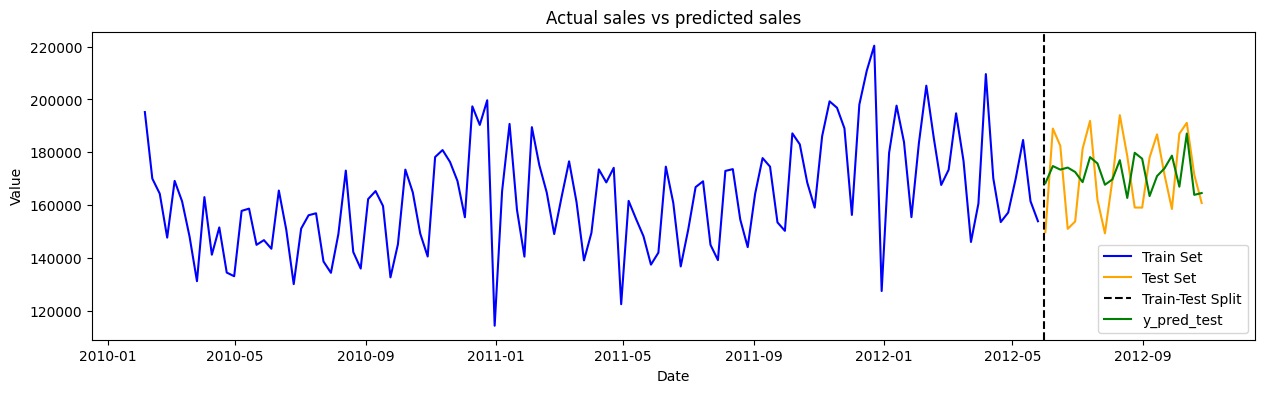

In [186]:
plot_train_test_split_pred (ts_store20, split_date,y_pred_rforestreg_tune_ts,test_color="orange", y_pred_color='green')

In [187]:
features_importance_rforestreg_tune = pd.DataFrame(list(zip(X_train.columns,best_model_rforestreg[1].feature_importances_)),columns=['Features','Importance_level'])
features_importance_rforestreg_tune.sort_values(by ='Importance_level',ascending=False)

,Features,Importance_level
0,IsHoliday,0.290467
9,MarkDown4,0.150694
10,MarkDown5,0.142338
2,Year,0.110516
1,Week,0.064773
3,Month,0.064772
7,MarkDown2,0.050486
8,MarkDown3,0.048853
12,Unemployment,0.027998
6,MarkDown1,0.026279


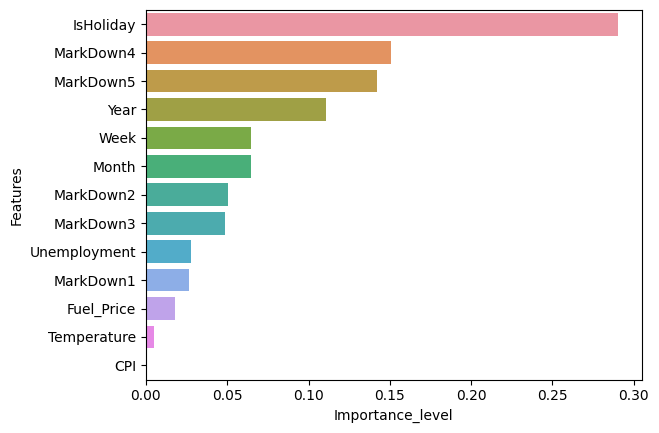

In [188]:
sns.barplot(data= features_importance_rforestreg_tune.sort_values(by ='Importance_level',ascending=False), y='Features',x='Importance_level');

In [189]:
summary_table.loc[6] = ['Rforestregressor', ' + tuning', round(RMSE_rforestreg_tune), round(mae_rforestreg_tune,2)]

summary_table

,Name,Model,RMSE,MAE
0,Baseline_1,Actual vs 1st lag,23330,18236.27
1,ARIMA_dif_1,Actual vs dif_1,14556,11977.52
2,SARIMAX,SARIMA,23072,20349.46
3,XGBRegressor,Without tuning,16804,14958.97
4,XGBRegressor,+ tuning,19508,17184.33
5,Rforestregressor,withou tuning,15638,14202.63
6,Rforestregressor,+ tuning,15187,13779.82


#### Analyze the forecasted sales error:

In [190]:
test.set_index('Date',inplace=True)

By analyzing the disparity between actual weekly sales and forecasted weekly sales, we can dive further to identify additional factors influencing sales and enhance future forecasts. 

In the case below, as an example, we can taking the top 5 and bottom 5 weeks to do further analysis.

In [191]:
rforestreg_tune_error = test['Weekly_Sales'] - test['y_pred_XGBoost_tune']
rforestreg_tune_error.sort_values(ascending=False)

Date
2012-06-08    34997.431875
2012-10-05    29287.440625
2012-10-19    27901.299375
2012-07-13    27367.543750
2012-08-17    25191.780000
2012-08-10    23236.573750
2012-07-06    20513.955625
2012-06-15    20416.659375
2012-09-21    18499.249375
2012-09-14    17263.281875
2012-09-07    13370.105000
2012-10-26    12570.839375
2012-10-12    10060.896875
2012-08-03     4476.616250
2012-07-20     3711.099375
2012-09-28    -1200.130000
2012-06-29    -4110.745625
2012-08-31    -5931.133125
2012-08-24   -12531.245000
2012-07-27   -21225.956250
2012-06-01   -21610.017500
2012-06-22   -22581.199375
dtype: float64

In [192]:
# Top 5 weeks that have significant LOW forecast vs actual
rforestreg_tune_error.sort_values(ascending=False)[:5]

Date
2012-06-08    34997.431875
2012-10-05    29287.440625
2012-10-19    27901.299375
2012-07-13    27367.543750
2012-08-17    25191.780000
dtype: float64

In [193]:
# Top 5 weeks that have significant HIGH forecast vs actual
rforestreg_tune_error.sort_values(ascending=False)[-5:]

Date
2012-08-31    -5931.133125
2012-08-24   -12531.245000
2012-07-27   -21225.956250
2012-06-01   -21610.017500
2012-06-22   -22581.199375
dtype: float64

In [195]:
abs(rforestreg_tune_error.sort_values(ascending=False))

Date
2012-06-08    34997.431875
2012-10-05    29287.440625
2012-10-19    27901.299375
2012-07-13    27367.543750
2012-08-17    25191.780000
2012-08-10    23236.573750
2012-07-06    20513.955625
2012-06-15    20416.659375
2012-09-21    18499.249375
2012-09-14    17263.281875
2012-09-07    13370.105000
2012-10-26    12570.839375
2012-10-12    10060.896875
2012-08-03     4476.616250
2012-07-20     3711.099375
2012-09-28     1200.130000
2012-06-29     4110.745625
2012-08-31     5931.133125
2012-08-24    12531.245000
2012-07-27    21225.956250
2012-06-01    21610.017500
2012-06-22    22581.199375
dtype: float64

In this analysis, we will not go further as the information is limited.

## 4. Model evaluation

In [196]:
summary_table

,Name,Model,RMSE,MAE
0,Baseline_1,Actual vs 1st lag,23330,18236.27
1,ARIMA_dif_1,Actual vs dif_1,14556,11977.52
2,SARIMAX,SARIMA,23072,20349.46
3,XGBRegressor,Without tuning,16804,14958.97
4,XGBRegressor,+ tuning,19508,17184.33
5,Rforestregressor,withou tuning,15638,14202.63
6,Rforestregressor,+ tuning,15187,13779.82


In this analysis, our focus will be on analyzing and modeling a specific department (92) within a specific store (20). We will evaluate the performance of the models using two key metrics: RMSE (root mean squared error) and MAE (mean absolute error). 

We have explored two classical time series models, namely ARIMA and SARIMAX, which involve several steps to decompose the trend and seasonality components. Removing the trend and seasonality is crucial to ensure accurate forecasts. However, considering the large number of combinations resulting from Walmart's 45 stores and 99 departments, applying these models at scale becomes inefficient. These models are time-consuming, complex, and require case-by-case analysis, making them impractical for forecasting in this context.

By utilizing machine learning models such as Random Forest Regressor and XGBoost Regressor, we can bypass the need for manually decomposing trends and seasonality. Instead, we can directly input relevant predictors or those we suspect to be influential into these models. They will then identify and highlight the factors that have the most significant impact on the predicted forecast. This approach allows us to easily scale up the forecast to include all stores and departments, resulting in a more efficient, convenient, and time-saving process.

Although the ARIMA model with the first time series differencing yielded the lowest RMSE and MAE, it is not suitable for scaling up to multiple stores and departments. Therefore, our best model choice is the Random Forest Regressor with tuning. The RMSE decreased from 23k (baseline model) to 18k, and the MAE decreased from 18k (baseline model) to 13.7k. Even though these errors are still relatively high, it is the best performance we can achieve with the current data. To further improve the model's predictions, we need to feed more data into the model for a better learning process.

One important point to highlight is that both RMSE and MAE are used to evaluate the model's performance, but I strongly prefer MAE in this analysis as MAE provides a reflection of the absolute error between the actual and predicted sales, and it is less sensitive to large errors compared to RMSE.

### Recommendation

- Holiday: As per the current status, the yearly holiday calendar was not fully updated in the data and there was a simple classification of Yes/No for holidays. I would suggest incorporating a comprehensive collection of annual holidays and categorizing them into broader classifications, such as big, medium, and small, based on their duration.

- Sale events: Sale events were not present in the available data, but I would suggest incorporating them by including yearly sale events categorized into different levels such as mega, big, medium, small, flash, etc. Adding sale events as an additional predictor in the model can enhance the accuracy of the predictions.

- Error analysis: since the forecast model is not perfect, we should review the forecast every month/quarter to find out which factors impact the errors and add that factors into the models as predictors.


### Limitation

The available data is limited, covering less than 3 years, with only the year 2012 having complete data for the entire year. Additionally, there are missing markdown information until Nov-2011, and the holiday data is not fully provided.